# Monkey Species detection using Transfer Learning

## For this model we have used Xception Model and modified the last layers

## Accuracy of the Model : 94.12% for the test data

In [1]:
import os
from pathlib import Path
import time
import PIL
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.applications import Xception
from tensorflow.python.keras.applications.vgg16 import decode_predictions
from tensorflow.python.keras.layers import Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


class MyModel:
    def __init__(self,epochs,steps_per_epoch,batch_size):
        self.epochs = epochs
        self.steps_per_epoch = steps_per_epoch
        self.batch_size = batch_size
        print("building model")
        self.model=None

    #Get the inception model
    def get_inception_model(self,shape):
        self.model = Xception(input_shape=shape,include_top=True, weights='imagenet')
        return self.model


    #build our Xception with custom layers. Transfer Learning
    def build(self,classes,model):
        transfer_layer = model.get_layer('avg_pool')
        conv_model = Model(inputs=model.input,
                           outputs=transfer_layer.output)
         # we would train only our changed last layers, we will not the weights of Xception
        conv_model.trainable = False
        #According to the experiments conducted, changing block 5 and block 4 to traininable gives out best results 
        for layer in conv_model.layers:
            if('block14' in layer.name or 'avg_pool' in layer.name):
                layer.trainable = True
            layer.trainable = False
        new_model = Sequential()
        new_model.add(conv_model)
        new_model.add(Dense(1024, activation='relu'))
        new_model.add(Dropout(0.5))
        new_model.add(Dense(n_classes, activation='softmax'))
        return new_model
    
    #Compile the model before training
    def compile_model(self,new_model):
        # our minimizer
        optimizer = Adam(lr=1e-5)
        loss = 'categorical_crossentropy'
        metrics = ['categorical_accuracy']
        new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # initialize the Keras in built Image generator, used for image manipulations
    def train_image_generator(self):
        img_generator = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1. / 255,
            rotation_range=180,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=[1.0, 1.5],
            fill_mode='nearest')
        return img_generator

    #get the input shape of our model
    def get_input_shape(self):
        return self.model.layers[0].output_shape[0:3]

    def test_image_generator(self):
        return ImageDataGenerator(rescale=1./255)

    # Method to return the image generator
    def train_data_generator(self,train_dir,shape):
        img_generator = self.train_image_generator()
        return img_generator.flow_from_directory(directory=train_dir,
                                                    target_size=shape,
                                                    batch_size=self.batch_size,
                                                    shuffle=True)
    
    def test_data_generator(self,test_directory,shape):
        img_generator = self.test_image_generator()
        return img_generator.flow_from_directory(directory=test_directory,
                                                  target_size=shape,
                                                  batch_size= self.batch_size,
                                                  shuffle=False)


    #prints the model layers, this is the in built functionality of keras
    def print_model_summary(self,model):
        model.summary()


    def train(self,new_model,train_data_generator,test_data_generator):
        new_model.summary()
        steps_test = self.steps_test(test_data_generator)
        print("Step test {0}".format(steps_test))
        class_weight = self.class_weight(train_data_generator)
        history = new_model.fit_generator(generator=train_data_generator,
                                          epochs=self.epochs,
                                          steps_per_epoch=self.steps_per_epoch,
                                          class_weight=class_weight,
                                          validation_data=test_data_generator,
                                          validation_steps=steps_test)
        return history,new_model

    # used to calculate the class weights which is used while training model, it helps the model to train properly
    #if there is an imbalance in the image numbers among the classes
    def class_weight(self,train_data_generator):
        cls_train = train_data_generator.classes
        class_weight = compute_class_weight(class_weight='balanced',
                                            classes=np.unique(cls_train),
                                            y=cls_train)
        return class_weight

    #Used in training step for validating
    def steps_test(self,test_data_generator):
        return test_data_generator.n / self.batch_size

    #Save the model
    def save_my_model(self,new_model):
        new_model.save('../data/xception_model.h5')

    #Load the saved Model
    def load_my_model(self):
        return load_model('../data/xception_model.h5')
    
    #Plot the accuracy
    def plot_training_history(self,history):
        accuracy = history.history['categorical_accuracy']
        validation_accuracy = history.history['val_categorical_accuracy']
        plt.figure(figsize=(10,10))
        plt.plot(accuracy, linestyle='-', color='b', label='Training Acc.')
        plt.plot(validation_accuracy, linestyle='--', color='r', label='Test Acc.')
        plt.title('Training and Test Accuracy')
        plt.legend()
        plt.show()
        
    #plot the loss     
    def plot_loss_history(self,history):
        train_loss = history.history['loss']
        test_loss = history.history['val_loss']
        plt.figure(figsize=(10,10))
        plt.plot(train_loss, linestyle='-', color='b', label='Training Loss')
        plt.plot(test_loss, linestyle='--', color='r', label='Test Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.show()
    
    #Evaluate our model against the test data
    def test_accuracy_evaluation(self,generator_test):
        result = new_model.evaluate_generator(generator_test, steps=modelObj.steps_test(test_data_generator=generator_test))
        print("Test-set classification accuracy: {0:.2%}".format(result[1]))
    

### Initialize the necessary Parameters
#### Load the xception model, load training and test images, build our ccustom model

In [2]:
#our training directory
train_directory = Path('../data/training')
#our test directory
test_directory = Path('../data/validation')

shape = (224,224,3)

# initialise the model
modelObj = MyModel(epochs=20, steps_per_epoch=100, batch_size=20)
model = modelObj.get_inception_model(shape)

#generator for our train data
input_shape =(224,224)
generator_train = modelObj.train_data_generator(train_directory,input_shape)
generator_test = modelObj.test_data_generator(test_directory,input_shape)

# number of classes of train data
n_classes = generator_train.num_class
new_model = modelObj.build(n_classes,model)
modelObj.compile_model(new_model)


building model
Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


## Test Accuracy before training

In [3]:
modelObj.test_accuracy_evaluation(generator_test=generator_test)

Test-set classification accuracy: 9.56%


### Train the model and find the time taken to train

In [4]:
start = time.time()
#new_model.summary()    
history,new_model = modelObj.train(new_model,generator_train,generator_test)
end = time.time()
print("\nTime taken to train for 20 epochs {0} minutes".format((end -start)/60))

#Save my model
modelObj.save_my_model(new_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 22,969,906
Trainable params: 2,108,426
Non-trainable params: 20,861,480
_________________________________________________________________
Step test 13.6
Epoch 1/20
100/100 [==============================] - 74s - loss: 2.2900 - categorical_accuracy: 0.1213 - val_loss: 2.0711 - val_categorical_accuracy: 0.3456
Epoch 2/20
100/100 [==============================] - 70s - loss: 2.2009 - catego

## Training and Test After Accuracy

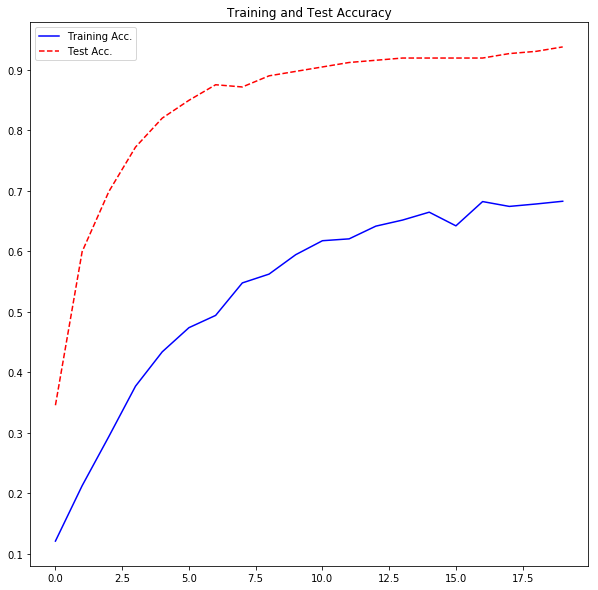

In [5]:
modelObj.plot_training_history(history)

## Training and Test Loss

In [6]:
modelObj.plot_loss_history(history)

## Model Accuracy 

In [7]:
modelObj.test_accuracy_evaluation(generator_test=generator_test)

Test-set classification accuracy: 93.75%


## Retraining the Xception Model

In [8]:
#our training directory
train_directory = Path('../data/training')
#our test directory
test_directory = Path('../data/validation')

# initialise the model
newModelObj = MyModel(epochs=20, steps_per_epoch=100, batch_size=20)

new_model = newModelObj.load_my_model()


#generator for our train data (224 was the best size according to our experiments)
generator_train = newModelObj.train_data_generator(train_directory,(224,224))
generator_test = newModelObj.test_data_generator(test_directory,(224,224))

# we are lowering the training speed here
optimizer = Adam(lr=1e-7)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

building model
Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Retraining

In [9]:
start = time.time()
#new_model.summary()    
history,new_model = newModelObj.train(new_model,generator_train,generator_test)
end = time.time()
print("\nTime taken to train for 20 epochs {0} minutes".format((end -start)/60))

#Save my model
newModelObj.save_my_model(new_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 22,969,906
Trainable params: 2,108,426
Non-trainable params: 20,861,480
_________________________________________________________________
Step test 13.6
Epoch 1/20
100/100 [==============================] - 89s - loss: 1.2011 - categorical_accuracy: 0.6843 - val_loss: 0.8431 - val_categorical_accuracy: 0.9375
Epoch 2/20
100/100 [==============================] - 86s - loss: 1.2046 - catego

## Training and Test Accuracy after Retraining the model

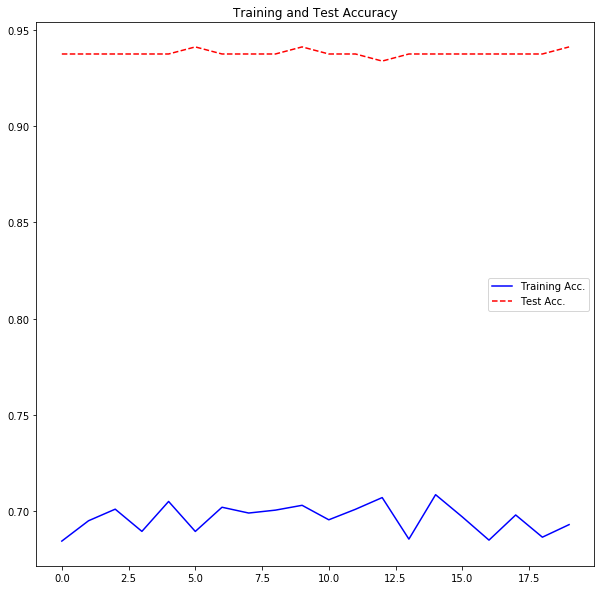

In [10]:
modelObj.plot_training_history(history)

## Training and Test Loss after Retraining

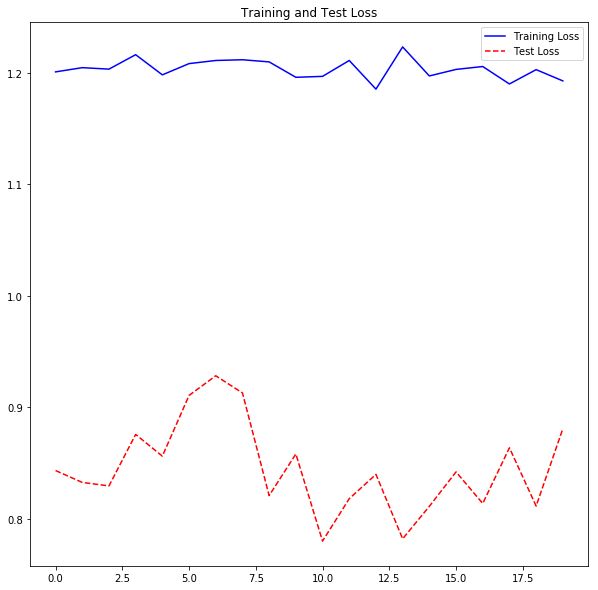

In [11]:
modelObj.plot_loss_history(history)

## Model Accuracy

In [12]:
modelObj.test_accuracy_evaluation(generator_test=generator_test)

Test-set classification accuracy: 94.12%
